In [1]:
#Load Packages

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


#Load Data
training = pd.read_csv("Training_Data.csv")
testing = pd.read_csv("Testing_Data.csv")

training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8203 entries, 0 to 8202
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pkey                   8203 non-null   int64  
 1   Renewed                8203 non-null   int64  
 2   num seats              8203 non-null   int64  
 3    total seat price      8152 non-null   object 
 4   account_type           8203 non-null   object 
 5   tenure                 8203 non-null   int64  
 6   section                8203 non-null   object 
 7   club_flag              8203 non-null   object 
 8   Email Open Rate        8203 non-null   float64
 9   State                  8200 non-null   object 
 10  Country                8200 non-null   object 
 11  Distance From Stadium  5845 non-null   float64
 12  Utilization Rate       8203 non-null   object 
 13  Age                    7157 non-null   float64
 14  income_est_hh_cd       7144 non-null   object 
dtypes: f

In [2]:
#Load training data and change utilization rate to a number
training = training[['num seats', 'tenure', 'account_type', 'club_flag', 'Utilization Rate', 'Renewed']]
training = training.fillna(training.median(numeric_only=True))

training['Utilization Rate'] = training['Utilization Rate'].str.rstrip('%').astype('float') / 100.0


#Split up the input and output values
X = training[['num seats', 'tenure', 'account_type', 'club_flag', 'Utilization Rate']]
y = training['Renewed']


#Create dummy variables for categorical variables
X = pd.get_dummies(X, drop_first=True)

In [3]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 99528081)

In [4]:
#Train model

rf_model = RandomForestClassifier(n_estimators=1000, random_state= 20022121)

rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=20022121)

In [5]:
#Predict values
y_val_pred = rf_model.predict(X_val)

#Evaluation of accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on Validation Set: {accuracy:.2f}")

Accuracy on Validation Set: 0.84


In [6]:
#Classification Report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.48      0.23      0.31       265
           1       0.87      0.95      0.91      1376

    accuracy                           0.84      1641
   macro avg       0.67      0.59      0.61      1641
weighted avg       0.80      0.84      0.81      1641



From our classifcation report, we are very happy with our results. Accuracy of 0.84 is good, but accuracy can be over influenced when classes are imbalanced, and so we look to some of our other statistics. Precision of 0.87 indicates that 87% of the people we say will renew their tickets actually did, 0.95 recall indicates that 0.95% of the people who actually renewed their season tickets were predicted to do so by my model and the 0.91 f1-score averages our precision and recall and indicates that we are doing a good job minimizing both Type I and Type II error, as there are very few false positives or negatives. Now we apply this to our test set

In [7]:
#Applying to test set

testing_sub = testing[['num seats', 'tenure', 'account_type', 'club_flag', 'Utilization Rate']]


testing_sub['Utilization Rate'] = testing_sub['Utilization Rate'].str.rstrip('%').astype('float') / 100.0


X_test = testing[['num seats', 'tenure', 'account_type', 'club_flag', 'Utilization Rate']]


X_test = pd.get_dummies(X_test, drop_first=True)


X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

/var/folders/67/gpz3f5nd55l_q5hmg7yqg9ww0000gn/T/ipykernel_28072/173066489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_sub['Utilization Rate'] = testing_sub['Utilization Rate'].str.rstrip('%').astype('float') / 100.0


In [8]:
#Predict probabilities from test set data
Renewal_Prob = rf_model.predict_proba(X_test)[:, 1]

In [9]:
#Adding probabilities to the dataset we will export
testing['Renewal_Prob'] = np.nan


testing.loc[X_test.index, 'Renewal_Prob'] = Renewal_Prob

In [10]:
#Quick view of data with new column added
testing.head(5)

,Pkey,num seats,total seat price,account_type,tenure,section,club_flag,Email Open Rate,State,Country,Distance From Stadium,Utilization Rate,Age,income_est_hh_cd,Renewal_Prob
0,1,4,"$4,350",Personal,30,100,Non-Club,0.3486,PA,United States,208.649698,100%,60.0,"$50,000 - $74,999",0.98940
1,2,5,"$4,294",Personal,15,100,Non-Club,0.0321,NY,United States,106.196447,100%,42.0,"Greater than $124,999",0.74925
2,3,4,"$4,050",Personal,57,100,Non-Club,0.3224,NY,United States,25.410607,100%,82.0,"$20,000 - $29,999",0.99375
3,4,4,"$4,050",Personal,48,100,Non-Club,0.0828,NY,United States,109.381533,100%,64.0,"$75,000 - $99,999",0.99375
4,5,5,"$3,150",Personal,42,200,Non-Club,0.1099,NY,United States,15.510371,100%,62.0,"$20,000 - $29,999",0.99325


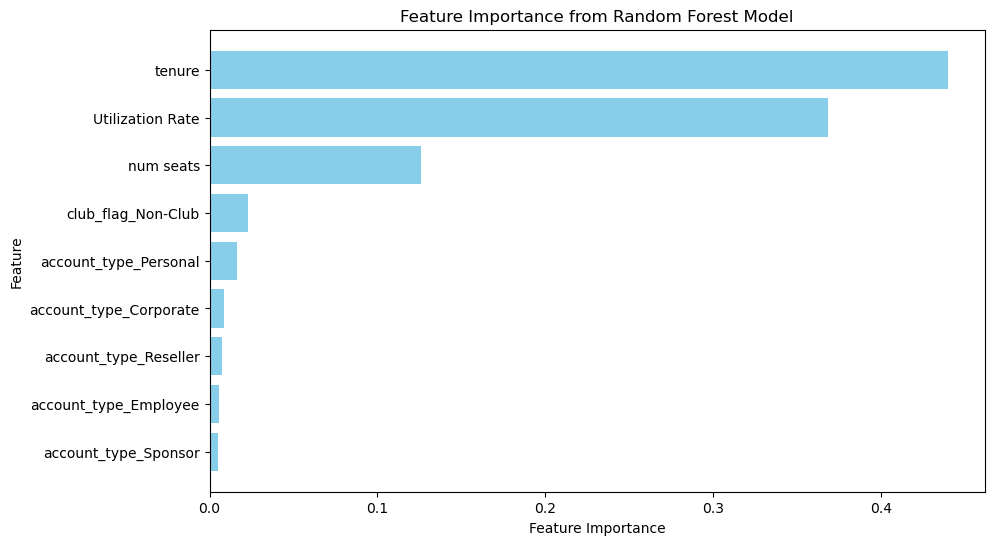

In [11]:
#Produce feature importance chart
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis() 
plt.show()

In [12]:
# Save the DataFrame to a CSV file
testing.to_csv('Testing_Data.csv', index=False)